<a href="https://colab.research.google.com/github/redhyppo/MAIMLF2020/blob/master/LC6_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementazione di modelli di Deep Learning Generativo: VAE e DCGAN 

### Informazioni ###

scopo: familiarizzare con lo sviluppo e utilizzo di reti neurali profonde di tipo VAE e GAN 

DL tool: tensorflow/keras

### Modelli e task ###

1.   implementazione di un Variational Auto Encoder addestrato sul dataset MNIST (da esempio di F.Chollet Keras/TF) + modifica in beta-VAE per promuovere diagonalizzazione dei prior dello spazio latente 
2.   implementazione di una DeepConvolutional GAN per la generazione di immagini del campione MNIST

Documentazione:

*   [VAE](https://arxiv.org/abs/1312.6114)
*   [beta-VAE](https://openreview.net/forum?id=Sy2fzU9gl)
*   [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)


**Datasets:**

*   MNIST benchmark from Tensorflow

### Parte 1: VAE ###

Ispirata ad esempio di F.Chollet di VAE per analisi dataset MNIST con modifica in beta-VAE

In [1]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [0]:
#leggiamo il dataset MNIST (le label non sono necessarie per la task)
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

#uniamo training e test set per avere più statistica
mnist_digits = np.concatenate([x_train, x_test], axis=0)

#reshaping da (70000, 28,28) -> (70000, 28, 28, 1) e normalizzazione a [0,1]
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [0]:
#Modello VAE

#Costruzione sampling layer (funzione che eredita dalla classe Layer)
#questo è il cosidetto Reparameterization Trick
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

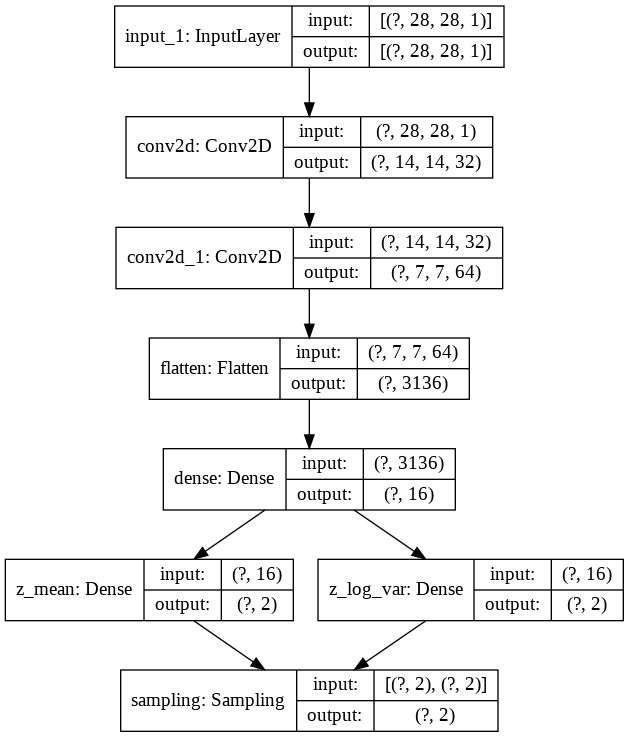

In [4]:
# Modello per l'ENCODER: immagine -> spazio latente

latent_dim = 2 #numero di dimensioni dello spazio latente

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# i valori dei parametri mu e sigma (log_sigma) sono scritti in layers densi senza attivazione
# notare come l'output x è passato in parallelo ai due layer densi

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling Layer: ritorna un vettore dello spazio latente z ottenuto campionando il prior 
# dello spazio latente 
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()
keras.utils.plot_model(encoder, show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

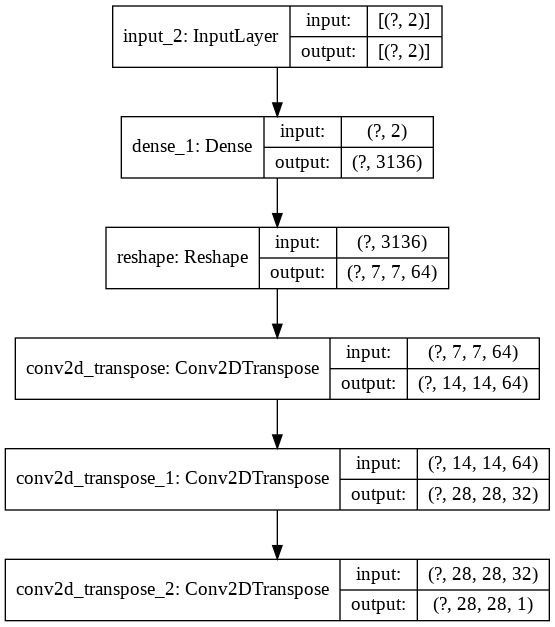

In [5]:
# Modello per il DECODER: spazio latente -> immagine

latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)

# usiamo Conv2DTranspose (upsampling convolutions) per passare da tensori 7,7 alle dimensioni 
# volute dell'immagine MNIST 28,28
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

#NOTA: ultima attivazione sigmoide (valore dei pixel normalizzati in [0,1])

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()
keras.utils.plot_model(decoder, show_shapes=True)

In [0]:
# Modello VAE completo
# È necessario costruire un modello "custom" in Tensorflow/Keras, questo perché una VAE 
# ha una struttura di loss non standard (reconstruction + KL)

# costruiamo una funzione (classe) che eredità da keras.Model e che prende in input il modello di 
# encoder e decoder che abbiamo definito sopra per costruire la VAE completa
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple): #controlla che data sia una python tuple come atteso per i tensori numpy
            data = data[0]
        with tf.GradientTape() as tape: #autograd 
            z_mean, z_log_var, z = encoder(data) #applica l'encoder su data e ottiene z_mean, z_log_var, z
            reconstruction = decoder(z) #applica il decoder su z e ottiene l'ouput 
            reconstruction_loss = tf.reduce_mean( #calcolo della reconstruction loss (binary cross-entropy tra input (data) e ouput (reconstruction))
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28 #applica la corretta definizione di reco_loss = d^2 \sum(...)
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) #KL-divergence for multinormal distribution
            kl_loss = tf.reduce_mean(kl_loss) #calcola la media sommando sulle dimensioni latenti 
            kl_loss *= -0.5  # KL_loss = -1/2 \sum (sigma + mu^2 + 1 - log(sigma)) 

            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights) #calcola i gradienti e aggiorna i pesi
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [7]:
# Instanziamento del modello VAE e Training

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 4s 8ms/step - loss: 212.9588 - reconstruction_loss: 211.2277 - kl_loss: 1.7311
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - loss: 190.6236 - reconstruction_loss: 188.4752 - kl_loss: 2.1483
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 184.9574 - reconstruction_loss: 182.9659 - kl_loss: 1.9914
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - loss: 180.4613 - reconstruction_loss: 178.4241 - kl_loss: 2.0372
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 175.5216 - reconstruction_loss: 172.9681 - kl_loss: 2.5535
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 165.8593 - reconstruction_loss: 162.7001 - kl_loss: 3.1592
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 159.2780 - reconstruction_loss: 155.7312 - kl_loss: 3.5468
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - l

### Visualizzazione spazio latente ###

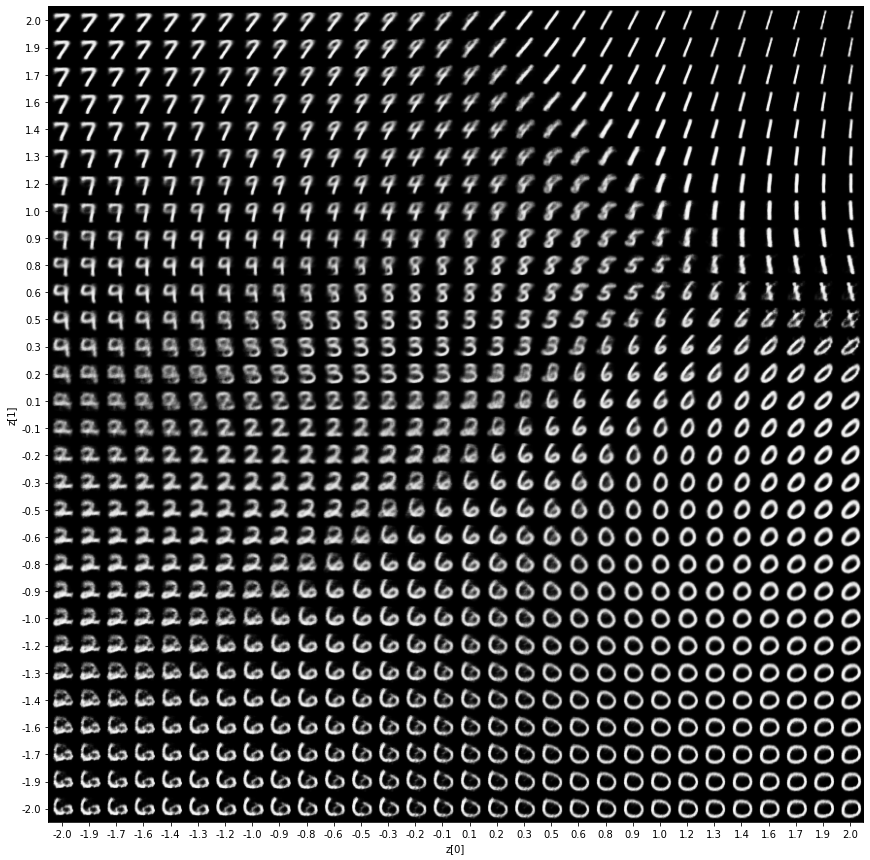

In [8]:
# grafica una matrice di nxn immagini generate dalla VAN in funzione del valore 
# della variabili [z1,z2] dello spazio latente bidimensionale

def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]]) #vettore z 
            x_decoded = decoder.predict(z_sample) #decoder(z)
            digit = x_decoded[0].reshape(digit_size, digit_size) #(28,28,1) -> (28,28)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(decoder)

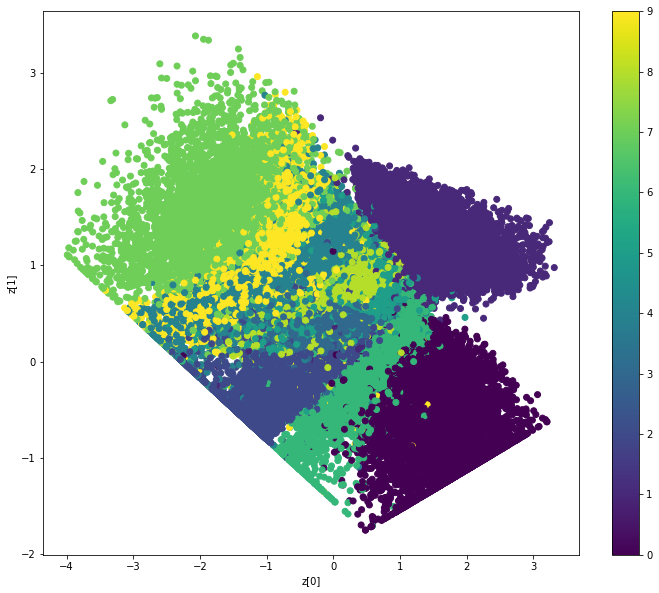

In [9]:
# Rappresentazione del dataset MNIST nello spazio latente 
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

z_mean, _, _ = encoder.predict(x_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [0]:
# beta-VAE: è una VAE in cui loss = reco_loss + beta * KL-divergence
# per beta=1 riotteniamo la VAE tradizionale, per beta>1 abbiamo un vincolo più forte sul collo di bottiglia 
# dello spazio latente e quindi incoraggiando rappresentazioni più efficienti 
# dello spazio latente (e indirettamente il disentangling tra le variabili latenti). 
#
# Beta funziona da iperparametro in cui si cerca di ottenere un compremesso tra disentangling e capacità di 
# ricostuire e generare buone immagini

# NOTA IMPORTANTE: ricordarsi di ri-inizalizare encoder e decoder sopra per resttare i pesi della rete

class betaVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(betaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        if isinstance(data, tuple): #controlla che data sia una python tuple come atteso per i tensori numpy
            data = data[0]
        with tf.GradientTape() as tape: #autograd 
            z_mean, z_log_var, z = encoder(data) #applica l'encoder su data e ottiene z_mean, z_log_var, z
            reconstruction = decoder(z) #applica il decoder su z e ottiene l'ouput 
            reconstruction_loss = tf.reduce_mean( #calcolo della reconstruction loss (binary cross-entropy tra input (data) e ouput (reconstruction))
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28 #applica la corretta definizione di reco_loss = d^2 \sum(...)
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) #KL-divergence for multinormal distribution
            kl_loss = tf.reduce_mean(kl_loss) #calcola la media sommando sulle dimensioni latenti 
            kl_loss *= -0.5  # KL_loss = -1/2 \sum (sigma + mu^2 + 1 - log(sigma)) 

            total_loss = reconstruction_loss + self.beta*kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights) #calcola i gradienti e aggiorna i pesi
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": self.beta*kl_loss,
        }

In [11]:
beta=10.0
betavae = betaVAE(encoder, decoder, beta)
betavae.compile(optimizer=keras.optimizers.Adam())
betavae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 4s 8ms/step - loss: 174.7147 - reconstruction_loss: 146.9497 - kl_loss: 27.7650
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - loss: 172.1978 - reconstruction_loss: 149.7426 - kl_loss: 22.4553
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - loss: 171.8893 - reconstruction_loss: 150.2158 - kl_loss: 21.6735
Epoch 4/30
547/547 [==============================] - 4s 8ms/step - loss: 171.6919 - reconstruction_loss: 150.3466 - kl_loss: 21.3453
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 171.4674 - reconstruction_loss: 150.3271 - kl_loss: 21.1404
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 171.3163 - reconstruction_loss: 150.3665 - kl_loss: 20.9498
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 171.1331 - reconstruction_loss: 150.3408 - kl_loss: 20.7924
Epoch 8/30
547/547 [==============================] - 4s 8ms/s

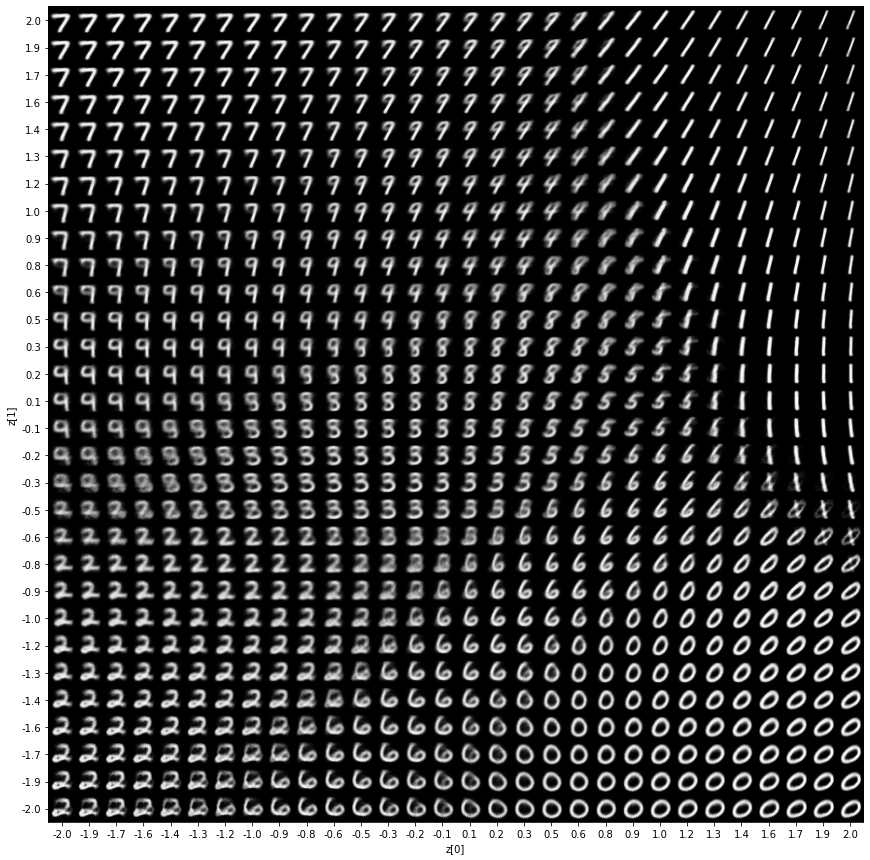

In [12]:
plot_latent(decoder)

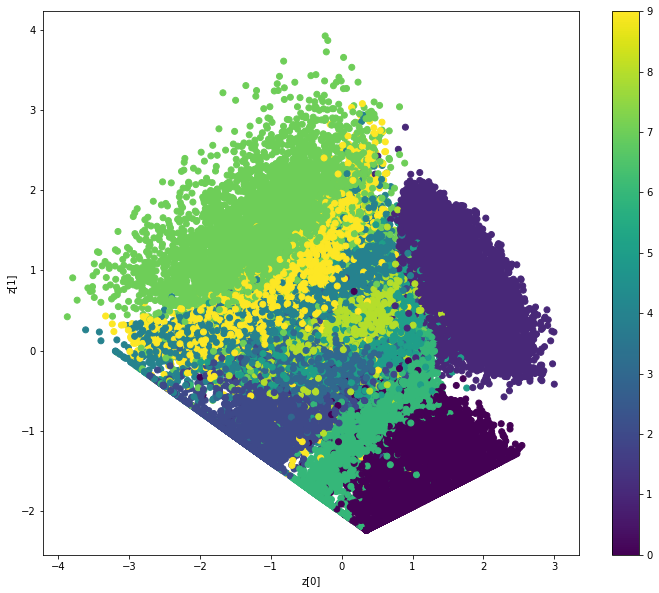

In [13]:
# Rappresentazione del dataset MNIST nello spazio latente 
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

z_mean, _, _ = encoder.predict(x_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


#**DCGAN**

In [0]:
### Parte 2: DCGAN ###

#La DCGAN è l'implementazione con Deep NN convoluzionali dell'idea originale di Goodfellow et Al, per la 
# generazioen di immagini artificiali 

In [0]:
#leggiamo il dataset MNIST (le label non sono necessarie per la task)
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

all_images = np.concatenate([x_train, x_test])
#normalize in 0,1
all_images = all_images.astype("float32") / 255
all_images = np.reshape(all_images, (-1, 28, 28, 1))
# create a TF dataset 
train_dataset = tf.data.Dataset.from_tensor_slices(all_images)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).prefetch(32)

In [16]:
# Modello DCGAN

# Discriminator: legge un immagine in input e decide se è vera o fake
# in pratica una semplice CNN in classificazione

IMG_SHAPE = (28, 28, 1)

def conv_block( #definizione blocco convoluzionale + BN + Dropout
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        img_input,
        64,
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)             

In [17]:
# Generator: campiona un vettore latente e genera un immagine

# usa upsampling (Conv2DTranspose) per passare da z -> immagine
# Size of latent vector (la dimensione del vettore latente z)
latent_dim = 128

def get_generator_model():
    z = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 256)(z)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(x)

    g_model = keras.models.Model(z, x, name="generator")
    return g_model

g_model = get_generator_model()
g_model.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       524416    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0 

In [0]:
# Modello DCGAN: implementiamo un keras.Model custom

class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # funzione per la compilazione
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple): #verifica che l'input isa una python tuple (numpy tensor)
            real_images = real_images[0]

        # 1) campiona un batch di punti random nello spazio latente: z
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2) usa il generatore per creare dai vettori latenti immagini fake: immagine = G(z)
        generated_images = self.generator(random_latent_vectors)

        # 3) combina le immagini fake con quelle reali 
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4) assegna le label corrette (fae vs reale)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # 5) Trucco per diminuire la probabilità di collasso della rete (si aggiunge un po' di rumore random alle label) 
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 6) Training del discriminatore D
        with tf.GradientTape() as tape: #autograd
            predictions = self.discriminator(combined_images) #predizione = D(immagini)
            d_loss = self.loss_fn(labels, predictions) #calcolo loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights) #backprop
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights) #aggiornamento pesi
        )

        # 7) campiona un nuovo batch di punti dello spazio latente: z
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 8) crea un vettore di label corrispondenti a tutte immagii reali
        misleading_labels = tf.zeros((batch_size, 1))

        # 9) Training del generatore (non si devono aggiornare ovviamente i pesi del discriminatore)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors)) #predizione = D(G(z))
            g_loss = self.loss_fn(misleading_labels, predictions) #calcolo loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights) #backprop
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights)) #aggiornamento pesi

        return {"d_loss": d_loss, "g_loss": g_loss}

In [0]:
# custom callback to save generated images peridoically during training
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128, norma=1.0):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.norma = norma

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * self.norma

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img2 = keras.preprocessing.image.array_to_img(img)
            img2.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
            img = img.reshape((28*28))
            np.savetxt("generated_img_{i}_{epoch}.dat".format(i=i, epoch=epoch), img)

In [0]:
# Training della GAN

# Ottimizzatori di G e D
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Loss function
gan_loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Epochs
EPOCHS = 20

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=latent_dim, norma=255)

# Istanziamento modello
gan = DCGAN(discriminator=d_model, generator=g_model, latent_dim=latent_dim)

# Compilazione
gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    loss_fn=gan_loss,
)

# Start training
gan.fit(train_dataset, epochs=EPOCHS, callbacks=[cbk])

In [0]:
from IPython.display import Image, display

display(Image("generated_img_0_19.png"))
display(Image("generated_img_1_19.png"))
display(Image("generated_img_2_19.png"))

In [0]:
# Controllo della qualità della generazione
# plot della distribuzione dell'intesità dei pixel nelle immagini reali e in quelle generate

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
real_img = x_train[:1000]
imgtmp = real_img.reshape((1000,28,28,1))
imgtmp = imgtmp / 255
pred_real = d_model(imgtmp)

random_latent_vectors = tf.random.normal(shape=(1000, latent_dim))
fake_img = g_model(random_latent_vectors)
fake_img = fake_img.numpy()
pred_fake = d_model(fake_img) #utile per la cella successiva
fake_img = fake_img.reshape((1000,28,28))
fake_img = fake_img * 255

fig, ax = plt.subplots(figsize=(6, 6))
_, bins, _ = plt.hist(real_img.ravel(), 
           bins=np.linspace(0, 255, 50), histtype='step', label='Real', color='purple')
_ = plt.hist(fake_img.ravel(), 
             bins=bins, histtype='step', label='GAN', color='green')

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend(loc='upper right')

In [0]:
# plot della distribuzione dell'output del discriminatore su immagini reali e in quelle generate

fig, ax = plt.subplots(figsize=(6, 6))
_, bins, _ = plt.hist(pred_real.numpy(), 
           bins=np.linspace(0, 1, 50), histtype='step', label='Real', color='purple')

_ = plt.hist(pred_fake.numpy(), 
             bins=bins, histtype='step', label='GAN', color='green')

plt.xlabel('Dsicriminator Output')
plt.yscale('log')
plt.legend(loc='upper right')


# **Compiti:** 

1.   beta-VAE: provare a giocare con il parametro beta e capire come influsice su disentangling VS capacità di ricostruzione 
2.   GAN: implementare la stessa GAN per generare immagini artificiali del campione *fashion_mnist* 
3.   GAN2 (opzionale e da fare dopo l'esercitazione): provare ad usare un campione di immagini di trainign di dimensione diversa da (28,28), modificando opportunamente D e G


NOTA: 

```
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
```



#**Beta-VAE**

Testiamo la dipendenza delle performance della beta_VAE al variare del parametro $\beta$.

In [0]:
# beta-VAE: è una VAE in cui loss = reco_loss + beta * KL-divergence
# per beta=1 riotteniamo la VAE tradizionale, per beta>1 abbiamo un vincolo più forte sul collo di bottiglia 
# dello spazio latente e quindi incoraggiando rappresentazioni più efficienti 
# dello spazio latente (e indirettamente il disentangling tra le variabili latenti). 
#
# Beta funziona da iperparametro in cui si cerca di ottenere un compremesso tra disentangling e capacità di 
# ricostuire e generare buone immagini

# NOTA IMPORTANTE: ricordarsi di ri-inizalizare encoder e decoder sopra per resttare i pesi della rete

class betaVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(betaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        if isinstance(data, tuple): #controlla che data sia una python tuple come atteso per i tensori numpy
            data = data[0]
        with tf.GradientTape() as tape: #autograd 
            z_mean, z_log_var, z = encoder(data) #applica l'encoder su data e ottiene z_mean, z_log_var, z
            reconstruction = decoder(z) #applica il decoder su z e ottiene l'ouput 
            reconstruction_loss = tf.reduce_mean( #calcolo della reconstruction loss (binary cross-entropy tra input (data) e ouput (reconstruction))
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28 #applica la corretta definizione di reco_loss = d^2 \sum(...)
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) #KL-divergence for multinormal distribution
            kl_loss = tf.reduce_mean(kl_loss) #calcola la media sommando sulle dimensioni latenti 
            kl_loss *= -0.5  # KL_loss = -1/2 \sum (sigma + mu^2 + 1 - log(sigma)) 

            total_loss = reconstruction_loss + self.beta*kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights) #calcola i gradienti e aggiorna i pesi
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": self.beta*kl_loss,
        }

In [23]:
beta=55.0
betavae = betaVAE(encoder, decoder, beta)
betavae.compile(optimizer=keras.optimizers.Adam())
betavae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 4s 8ms/step - loss: 206.0839 - reconstruction_loss: 205.1441 - kl_loss: 0.9398
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - loss: 206.0353 - reconstruction_loss: 205.2615 - kl_loss: 0.7738
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - loss: 206.0384 - reconstruction_loss: 205.3457 - kl_loss: 0.6927
Epoch 4/30
547/547 [==============================] - 4s 8ms/step - loss: 206.0544 - reconstruction_loss: 205.3612 - kl_loss: 0.6932
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 206.0148 - reconstruction_loss: 205.2700 - kl_loss: 0.7448
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 206.0392 - reconstruction_loss: 205.3377 - kl_loss: 0.7015
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 206.0838 - reconstruction_loss: 205.3670 - kl_loss: 0.7169
Epoch 8/30
547/547 [==============================] - 4s 8ms/step - l

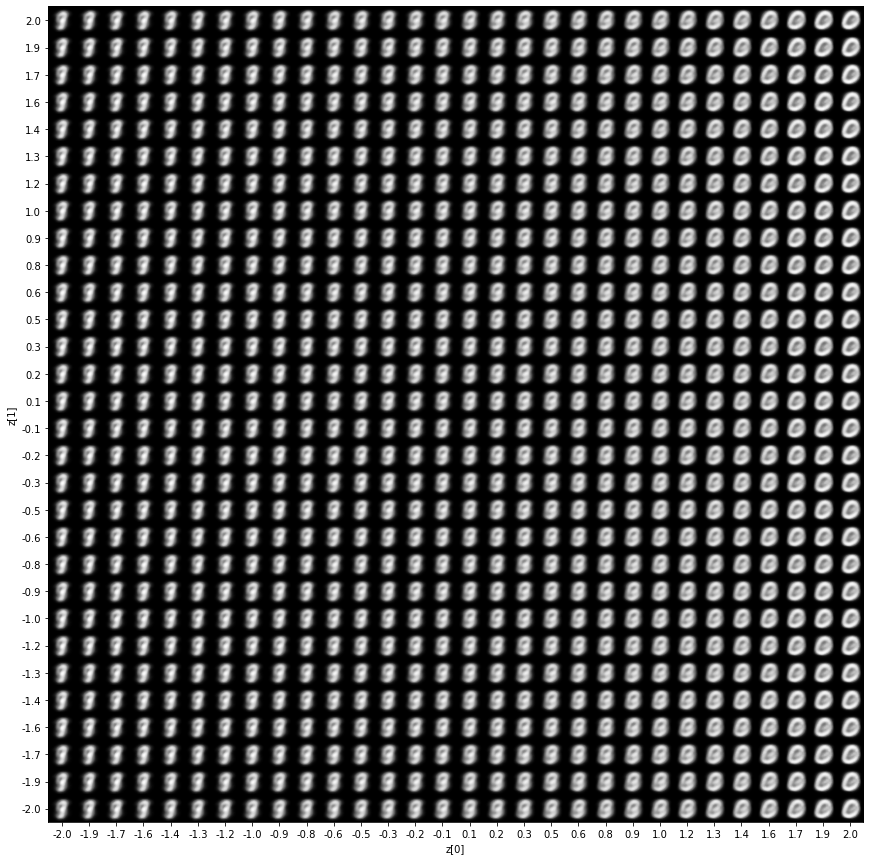

In [24]:
plot_latent(decoder)

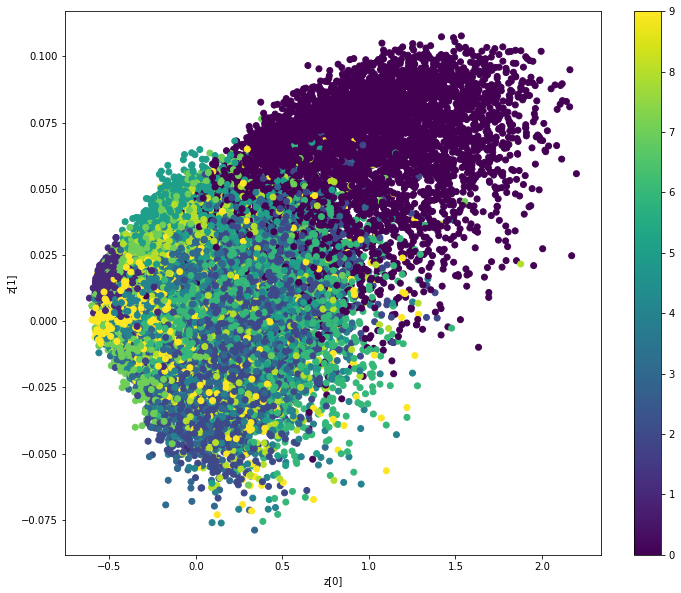

In [25]:
# Rappresentazione del dataset MNIST nello spazio latente 
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

z_mean, _, _ = encoder.predict(x_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


Dopo aver effettuato diversi tentativi, il risultato migliore è stato ottenuto ponendo $\beta=55$. Per valori minori, infatti, osserviamo degli allineamenti di diversi punti dello spazio latente (cosa che vogliamo evitare), mentre per valori maggiori i punti caratterizzati dalla stessa label non sono sufficientemente ravvicinati da accettare il risultato. <br />
L'algoritmo riesce ad inviduare nitidamente due regioni (la fucsia e la viola), mentre altre (come la gialla) sono solo accennate.